In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from collections import defaultdict

import numpy as np
import pandas as pd

from gptchem.data import get_qmug_data
from gptchem.evaluator import is_valid
from gptchem.extractor import InverseExtractor
from gptchem.formatter import InverseDesignFormatter
from gptchem.plotsettings import *
from gptchem.querier import Querier
from gptchem.tuner import Tuner

In [3]:
num_samples = 100
TEMPERATURES = [0.0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5]

In [4]:
def generate_desired_dist(mean: float = 5.0, width: float = 0.2, num_points: int = 100):
    return np.random.normal(mean, width, size=num_points)

In [5]:
formatter = InverseDesignFormatter(
    representation_column="SMILES",
    property_columns=["GFN2_HOMO_LUMO_GAP_mean_ev"],
    property_names=["bandgap"],
    num_digits=1,
)

In [6]:
tuner = Tuner()

In [7]:
extractor = InverseExtractor()

# Iteration 0


In [6]:
data = get_qmug_data()

In [4]:
train_set = data.sample(num_samples)

In [14]:
train_set["GFN2_HOMO_LUMO_GAP_mean_ev"].mean()

2.585626760870966

In [8]:
formatted_0 = formatter(train_set)

In [10]:
tune_res_0 = tuner(formatted_0)

Upload progress: 100%|██████████| 45.0k/45.0k [00:00<00:00, 21.1Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_170232/train.jsonl: file-nYMwTmPBskIID3jKNgtKtdxf


wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin


A run for fine-tune ft-t24yOKINJbekcMBORKwIpS5C was previously created but didn't end successfully
A new wandb run will be created for fine-tune ft-t24yOKINJbekcMBORKwIpS5C and previous run will be overwritten


wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.7
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/wandb/run-20230209_182516-ft-t24yOKINJbekcMBORKwIpS5C
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-t24yOKINJbekcMBORKwIpS5C
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-t24yOKINJbekcMBORKwIpS5C
Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/cli.py", line 527, in sync
   

In [12]:
tune_res_0

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_170232',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_170232/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-lsmoepfl-2023-02-09-17-22-56',
 'ft_id': 'ft-KYUUSQvS2nkwk6r1bA68dLdy',
 'date': '20230209_182529',
 'train_file_id': 'file-nYMwTmPBskIID3jKNgtKtdxf',
 'valid_file_id': None}

In [9]:
querier_0 = Querier("ada:ft-lsmoepfl-2023-02-09-17-22-56", max_tokens=600)

In [10]:
expected_gaps_0 = generate_desired_dist(3.5, 0.2, 1000)

In [11]:
expected_frame_0 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 1000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_0}
)

In [12]:
formatted_test_0 = formatter(expected_frame_0)

In [13]:
completions_0 = defaultdict(list)
smiles_0 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_0(formatted_test_0, temperature=temp)
        extracted = extractor(completions)
        completions_0[temp] = completions
        smiles_0[temp] = extracted
    except Exception:
        pass

In [18]:
unique_smiles_0 = set()
for t, v in smiles_0.items():
    unique_smiles_0.update(v)

In [19]:
len(unique_smiles_0)

4099

In [21]:
valid_smiles_0 = [s for s in unique_smiles_0 if is_valid(s)]

In [22]:
len(valid_smiles_0)

178

In [24]:
with open("xtb_inputs/0.txt", "w") as handle:
    for smile in valid_smiles_0:
        handle.write(smile + "\n")

In [26]:
with open("xtb_inputs/0_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_0, 100):
        handle.write(smile + "\n")

In [27]:
train_0 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_170232/train.jsonl",
    lines=True,
)

In [38]:
train_0["gap"] = train_0["representation"].apply(lambda x: x[0])

In [5]:
xtb_outputs_0 = pd.read_csv("xtb_outputs/0.csv")

(array([ 1.,  2.,  1.,  5.,  4.,  8.,  4.,  3.,  3.,  7., 11.,  9., 11.,
         9.,  7.,  2.,  3.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.34340049,  0.58116254,  0.8189246 ,  1.05668666,  1.29444871,
         1.53221077,  1.76997282,  2.00773488,  2.24549694,  2.48325899,
         2.72102105,  2.95878311,  3.19654516,  3.43430722,  3.67206928,
         3.90983133,  4.14759339,  4.38535545,  4.6231175 ,  4.86087956,
         5.09864162,  5.33640367,  5.57416573,  5.81192779,  6.04968984,
         6.2874519 ,  6.52521396,  6.76297601,  7.00073807,  7.23850012,
         7.47626218,  7.71402424,  7.95178629,  8.18954835,  8.42731041,
         8.66507246,  8.90283452,  9.14059658,  9.37835863,  9.61612069,
         9.85388275, 10.0916448 , 10.32940686, 10.56716892, 10.80493097,
        11.04269303, 11.28045509, 11.51821714, 11.7559792 ,

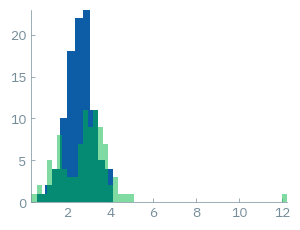

In [11]:
plt.hist(train_0["gap"])
plt.hist(xtb_outputs_0["gaps"], alpha=0.5, bins=50)

## 1st iteration


In [41]:
train_data_1 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list() + xtb_outputs_0["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list() + xtb_outputs_0["gaps"].to_list(),
    }
)

In [43]:
train_data_1.dropna(inplace=True)

In [47]:
train_data_1_selected = train_data_1[train_data_1["GFN2_HOMO_LUMO_GAP_mean_ev"] > 2.5]

In [48]:
len(train_data_1_selected)

121

In [49]:
formatted_1 = formatter(train_data_1_selected)

In [50]:
tune_res_1 = tuner(formatted_1)

Upload progress: 100%|██████████| 50.8k/50.8k [00:00<00:00, 49.3Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_222854/train.jsonl: file-LXxUjqsHvueMeCFZ6VjJD9EV


wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin


A run for fine-tune ft-t24yOKINJbekcMBORKwIpS5C was previously created but didn't end successfully
A new wandb run will be created for fine-tune ft-t24yOKINJbekcMBORKwIpS5C and previous run will be overwritten


wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.7
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/wandb/run-20230210_033523-ft-t24yOKINJbekcMBORKwIpS5C
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-t24yOKINJbekcMBORKwIpS5C
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-t24yOKINJbekcMBORKwIpS5C
Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/cli.py", line 527, in sync
   

In [51]:
tune_res_1

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_222854',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_222854/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-lsmoepfl-2023-02-10-02-32-57',
 'ft_id': 'ft-AphrpbwXTGF1sKHIaWFA5GxI',
 'date': '20230210_033537',
 'train_file_id': 'file-LXxUjqsHvueMeCFZ6VjJD9EV',
 'valid_file_id': None}

In [52]:
querier_1 = Querier("ada:ft-lsmoepfl-2023-02-10-02-32-57", max_tokens=600)

In [53]:
expected_gaps_1 = generate_desired_dist(4.5, 0.2, 2000)

In [54]:
expected_frame_1 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_1}
)

In [55]:
formatted_test_1 = formatter(expected_frame_1)

In [56]:
completions_1 = defaultdict(list)
smiles_1 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_1(formatted_test_1, temperature=temp)
        extracted = extractor(completions)
        completions_1[temp] = completions
        smiles_1[temp] = extracted
    except Exception:
        pass

In [58]:
unique_smiles_1 = set()
for t, v in smiles_1.items():
    unique_smiles_1.update(v)

In [59]:
len(unique_smiles_1)

2148

In [60]:
valid_smiles_1 = [s for s in unique_smiles_1 if is_valid(s)]

In [61]:
len(valid_smiles_1)

644

In [62]:
with open("xtb_inputs/1.txt", "w") as handle:
    for smile in valid_smiles_1:
        handle.write(smile + "\n")

In [64]:
with open("xtb_inputs/1_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_1, 100):
        handle.write(smile + "\n")

In [7]:
train_1 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230209_222854/train.jsonl",
    lines=True,
)
train_1["gap"] = train_1["representation"].apply(lambda x: x[0])
xtb_outputs_1 = pd.read_csv("xtb_outputs/1.csv")
plt.hist(train_0["gap"])
# plt.hist(train_1['gap'], bins=50)
plt.hist(xtb_outputs_1["gaps"], alpha=0.5, bins=100)

NameError: name 'train_0' is not defined

## Second iteration


In [14]:
train_data_2 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list()
        + xtb_outputs_0["smiles"].to_list()
        + train_1["label"].to_list()
        + xtb_outputs_1["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list()
        + xtb_outputs_0["gaps"].to_list()
        + train_1["gap"].to_list()
        + xtb_outputs_1["gaps"].to_list(),
    }
)

In [15]:
train_data_2.dropna(inplace=True)

<AxesSubplot: >

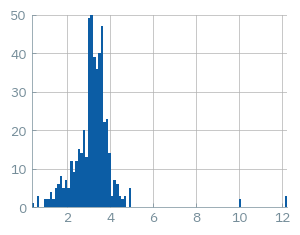

In [16]:
train_data_2["GFN2_HOMO_LUMO_GAP_mean_ev"].hist(bins=100)

In [17]:
train_data_2_selected = train_data_2[train_data_2["GFN2_HOMO_LUMO_GAP_mean_ev"] > 3]

In [18]:
len(train_data_2_selected)

344

In [19]:
formatted_2 = formatter(train_data_2_selected)

In [21]:
tune_res_2 = tuner(formatted_2)

Upload progress: 100%|██████████| 141k/141k [00:00<00:00, 99.1Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210/train.jsonl: file-T6oxh1ocCq2rxcCwPeUOxoNw


wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.7
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/wandb/run-20230211_043955-ft-ELdTIxvhC4puGJyiOhMCEaUW
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-ELdTIxvhC4puGJyiOhMCEaUW
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-ELdTIxvhC4puGJyiOhMCEaUW
Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/

In [22]:
tune_res_2

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-lsmoepfl-2023-02-11-03-37-08',
 'ft_id': 'ft-0ukqRtb8zQDe7m8jmuQ90oJD',
 'date': '20230211_044008',
 'train_file_id': 'file-T6oxh1ocCq2rxcCwPeUOxoNw',
 'valid_file_id': None}

In [23]:
querier_2 = Querier("ada:ft-lsmoepfl-2023-02-11-03-37-08", max_tokens=600)

In [24]:
expected_gaps_2 = generate_desired_dist(5.5, 0.2, 2000)

In [25]:
expected_frame_2 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_2}
)

In [26]:
formatted_test_2 = formatter(expected_frame_2)

In [27]:
completions_2 = defaultdict(list)
smiles_2 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_2(formatted_test_2, temperature=temp)
        extracted = extractor(completions)
        completions_2[temp] = completions
        smiles_2[temp] = extracted
    except Exception:
        pass

In [28]:
unique_smiles_2 = set()
for t, v in smiles_2.items():
    unique_smiles_2.update(v)

In [29]:
len(unique_smiles_2)

3027

In [30]:
valid_smiles_2 = [s for s in unique_smiles_2 if is_valid(s)]

In [31]:
with open("xtb_inputs/2.txt", "w") as handle:
    for smile in valid_smiles_2:
        handle.write(smile + "\n")

In [32]:
with open("xtb_inputs/2_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_2, 100):
        handle.write(smile + "\n")

## Third iteration


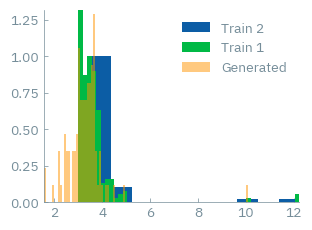

In [8]:
train_2 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210/train.jsonl",
    lines=True,
)
train_2["gap"] = train_2["representation"].apply(lambda x: x[0])
xtb_outputs_2 = pd.read_csv("xtb_outputs/2.csv")
plt.hist(train_2["gap"], density=True, label="Train 2")
plt.hist(train_1["gap"], bins=50, density=True, label="Train 1")
plt.hist(xtb_outputs_1["gaps"], alpha=0.5, bins=100, label="Generated", density=True)
plt.legend()

In [41]:
train_data_3 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list()
        + xtb_outputs_0["smiles"].to_list()
        + train_1["label"].to_list()
        + xtb_outputs_1["smiles"].to_list()
        + train_2["label"].to_list()
        + xtb_outputs_2["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list()
        + xtb_outputs_0["gaps"].to_list()
        + train_1["gap"].to_list()
        + xtb_outputs_1["gaps"].to_list()
        + train_2["gap"].to_list()
        + xtb_outputs_2["gaps"].to_list(),
    }
)

In [42]:
train_data_3.dropna(inplace=True)

<AxesSubplot: >

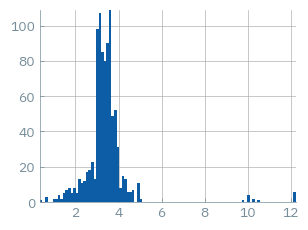

In [45]:
train_data_3["GFN2_HOMO_LUMO_GAP_mean_ev"].hist(bins=100)

In [46]:
train_data_3_selected = train_data_3[train_data_3["GFN2_HOMO_LUMO_GAP_mean_ev"] > 3.5]

In [48]:
formatted_3 = formatter(train_data_3_selected)

In [52]:
tune_res_3 = tuner(formatted_3)

Upload progress: 100%|██████████| 131k/131k [00:00<00:00, 205Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210/train.jsonl: file-EfZM3QJRiTMk4PyaGwG7S6Qi


wandb: Currently logged in as: kjappelbaum. Use `wandb login --relogin` to force relogin


A run for fine-tune ft-ELdTIxvhC4puGJyiOhMCEaUW was previously created but didn't end successfully
A new wandb run will be created for fine-tune ft-ELdTIxvhC4puGJyiOhMCEaUW and previous run will be overwritten


wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.13.7
wandb: Run data is saved locally in /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/wandb/run-20230211_154851-ft-ELdTIxvhC4puGJyiOhMCEaUW
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-ELdTIxvhC4puGJyiOhMCEaUW
wandb: ⭐️ View project at https://wandb.ai/kjappelbaum/GPT-3
wandb: 🚀 View run at https://wandb.ai/kjappelbaum/GPT-3/runs/ft-ELdTIxvhC4puGJyiOhMCEaUW
Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/openai/cli.py", line 527, in sync
   

In [53]:
tune_res_3

[autoreload of numpy.core.multiarray failed: Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/numpy/core/multiarray.py", line 16, in <module>
    from ._multiarray_umath import (
ImportError: cannot import name

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-personal-2023-02-11-14-42-29',
 'ft_id': 'ft-0DlmSA4MEMCMAjDo8HqtRqza',
 'date': '20230211_154904',
 'train_file_id': 'file-EfZM3QJRiTMk4PyaGwG7S6Qi',
 'valid_file_id': None}

In [8]:
querier_3 = Querier("ada:ft-personal-2023-02-11-14-42-29", max_tokens=600)

In [9]:
expected_gaps_3 = generate_desired_dist(6.5, 0.2, 2000)

In [10]:
expected_frame_3 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_3}
)

In [11]:
formatted_test_3 = formatter(expected_frame_3)

In [15]:
completions_3 = defaultdict(list)
smiles_3 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_3(formatted_test_3, temperature=temp)
        extracted = extractor(completions)
        completions_3[temp] = completions
        smiles_3[temp] = extracted
    except Exception:
        pass

In [16]:
unique_smiles_3 = set()
for t, v in smiles_3.items():
    unique_smiles_3.update(v)

In [17]:
len(unique_smiles_3)

569

In [18]:
valid_smiles_3 = [s for s in unique_smiles_3 if is_valid(s)]

In [19]:
len(valid_smiles_3)

389

In [20]:
with open("xtb_inputs/3.txt", "w") as handle:
    for smile in valid_smiles_3:
        handle.write(smile + "\n")

In [21]:
with open("xtb_inputs/3_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_3, 100):
        handle.write(smile + "\n")

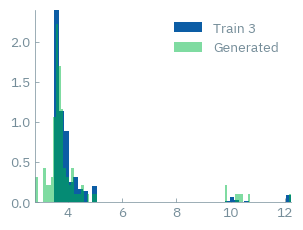

In [9]:
train_3 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230210_181210/train.jsonl",
    lines=True,
)
train_3["gap"] = train_3["representation"].apply(lambda x: x[0])
xtb_outputs_3 = pd.read_csv("xtb_outputs/3.csv")
plt.hist(train_3["gap"], bins=50, density=True, label="Train 3")
plt.hist(xtb_outputs_3["gaps"], alpha=0.5, bins=100, label="Generated", density=True)
plt.legend()

## Iteration 4


In [39]:
train_data_4 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list()
        + xtb_outputs_0["smiles"].to_list()
        + train_1["label"].to_list()
        + xtb_outputs_1["smiles"].to_list()
        + train_2["label"].to_list()
        + xtb_outputs_2["smiles"].to_list()
        + train_3["label"].to_list()
        + xtb_outputs_3["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list()
        + xtb_outputs_0["gaps"].to_list()
        + train_1["gap"].to_list()
        + xtb_outputs_1["gaps"].to_list()
        + train_2["gap"].to_list()
        + xtb_outputs_2["gaps"].to_list()
        + train_3["gap"].to_list()
        + xtb_outputs_3["gaps"].to_list(),
    }
)

<AxesSubplot: >

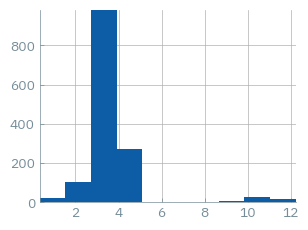

In [40]:
train_data_4["GFN2_HOMO_LUMO_GAP_mean_ev"].hist()

In [42]:
train_data_4.dropna(inplace=True)

In [47]:
train_data_4_selected = train_data_4[train_data_4["GFN2_HOMO_LUMO_GAP_mean_ev"] > 4]

In [48]:
len(train_data_4_selected)

269

In [49]:
formatted_4 = formatter(train_data_4_selected)

In [50]:
tune_res_4 = tuner(formatted_4)

Upload progress: 100%|██████████| 74.7k/74.7k [00:00<00:00, 36.9Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl: file-0U1hSBJGmChCN7axoYsVZwhr
Fine-tune ft-TOztw1CpQzXH88dFy1Nlnck8 has the status "failed" and will not be logged
🎉 wandb sync completed successfully


In [52]:
tune_res_4

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-personal-2023-02-11-16-50-35',
 'ft_id': 'ft-BtjCl5k1TVE01Tkc2OhPXipt',
 'date': '20230211_175428',
 'train_file_id': 'file-0U1hSBJGmChCN7axoYsVZwhr',
 'valid_file_id': None}

In [53]:
querier_4 = Querier("ada:ft-personal-2023-02-11-16-50-35", max_tokens=600)

In [54]:
expected_gaps_4 = generate_desired_dist(7.5, 0.2, 2000)

In [55]:
expected_frame_4 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_4}
)

In [56]:
formatted_test_4 = formatter(expected_frame_4)

In [57]:
completions_4 = defaultdict(list)
smiles_4 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_4(formatted_test_4, temperature=temp)
        extracted = extractor(completions)
        completions_4[temp] = completions
        smiles_4[temp] = extracted
    except Exception:
        pass

In [58]:
unique_smiles_4 = set()
for t, v in smiles_4.items():
    unique_smiles_4.update(v)

In [59]:
len(unique_smiles_4)

914

In [60]:
valid_smiles_4 = [s for s in unique_smiles_4 if is_valid(s)]

In [62]:
len(valid_smiles_4)

301

In [63]:
with open("xtb_inputs/4.txt", "w") as handle:
    for smile in valid_smiles_4:
        handle.write(smile + "\n")

In [64]:
with open("xtb_inputs/4_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_4, 100):
        handle.write(smile + "\n")

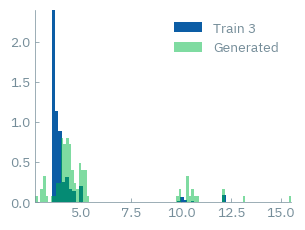

In [10]:
xtb_outputs_4 = pd.read_csv("xtb_outputs/4.csv")
plt.hist(train_3["gap"], bins=50, density=True, label="Train 3")
plt.hist(xtb_outputs_4["gaps"], alpha=0.5, bins=100, label="Generated", density=True)
plt.legend()

In [66]:
import seaborn as sns

(0.0, 8.0)

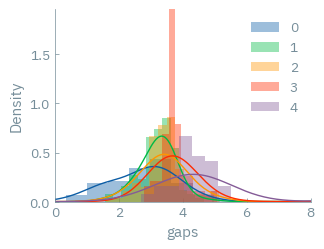

In [88]:
sns.distplot(xtb_outputs_0["gaps"], label="0")
sns.distplot(xtb_outputs_1["gaps"], label="1")
sns.distplot(xtb_outputs_2["gaps"], label="2")
sns.distplot(xtb_outputs_3["gaps"], label="3")
sns.distplot(xtb_outputs_4["gaps"], label="4")
plt.legend()

plt.xlim(0, 8)

## Iteration 5


In [74]:
train_4 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl",
    lines=True,
)
train_4["gap"] = train_4["representation"].apply(lambda x: x[0])

In [75]:
train_data_5 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list()
        + xtb_outputs_0["smiles"].to_list()
        + train_1["label"].to_list()
        + xtb_outputs_1["smiles"].to_list()
        + train_2["label"].to_list()
        + xtb_outputs_2["smiles"].to_list()
        + train_3["label"].to_list()
        + xtb_outputs_3["smiles"].to_list()
        + train_4["label"].to_list()
        + xtb_outputs_4["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list()
        + xtb_outputs_0["gaps"].to_list()
        + train_1["gap"].to_list()
        + xtb_outputs_1["gaps"].to_list()
        + train_2["gap"].to_list()
        + xtb_outputs_2["gaps"].to_list()
        + train_3["gap"].to_list()
        + xtb_outputs_3["gaps"].to_list()
        + train_4["gap"].to_list()
        + xtb_outputs_4["gaps"].to_list(),
    }
)

<AxesSubplot: >

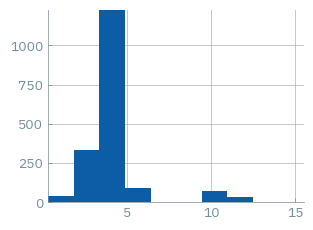

In [77]:
train_data_5["GFN2_HOMO_LUMO_GAP_mean_ev"].hist()

In [78]:
train_data_5.dropna(inplace=True)

In [84]:
train_data_5_selected = train_data_5[train_data_5["GFN2_HOMO_LUMO_GAP_mean_ev"] > 4.5]

In [85]:
len(train_data_5_selected)

275

In [86]:
formatted_5 = formatter(train_data_5_selected)

In [87]:
tune_res_5 = tuner(formatted_5)

Upload progress: 100%|██████████| 70.5k/70.5k [00:00<00:00, 75.0Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl: file-OEyLDs8AMuDL5OY232FwAzRe
Fine-tune ft-TOztw1CpQzXH88dFy1Nlnck8 has the status "failed" and will not be logged
🎉 wandb sync completed successfully


In [89]:
tune_res_5

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-personal-2023-02-11-19-04-14',
 'ft_id': 'ft-yreOOlZBJWijY10Uju2pKmzB',
 'date': '20230211_200749',
 'train_file_id': 'file-OEyLDs8AMuDL5OY232FwAzRe',
 'valid_file_id': None}

In [90]:
querier_5 = Querier("ada:ft-personal-2023-02-11-19-04-14", max_tokens=600)

In [91]:
expected_gaps_5 = generate_desired_dist(7.5, 0.2, 2000)

In [92]:
expected_frame_5 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_5}
)

In [93]:
formatted_test_5 = formatter(expected_frame_5)

In [94]:
completions_5 = defaultdict(list)
smiles_5 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_5(formatted_test_5, temperature=temp)
        extracted = extractor(completions)
        completions_5[temp] = completions
        smiles_5[temp] = extracted
    except Exception:
        pass

In [116]:
unique_smiles_5 = set()
for t, v in smiles_5.items():
    unique_smiles_5.update(v)

In [117]:
len(unique_smiles_5)

374

In [127]:
valid_smiles_5 = [s.split()[0].split("【")[0] for s in unique_smiles_5 if is_valid(s)]

In [128]:
len(valid_smiles_5)

203

In [129]:
with open("xtb_inputs/5.txt", "w") as handle:
    for smile in valid_smiles_5:
        handle.write(smile + "\n")

In [130]:
with open("xtb_inputs/5_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_5, 100):
        handle.write(smile + "\n")

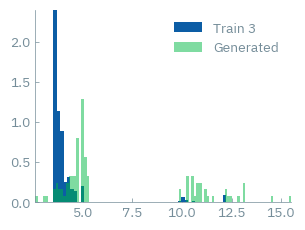

In [11]:
xtb_outputs_5 = pd.read_csv("xtb_outputs/5.csv")
plt.hist(train_3["gap"], bins=50, density=True, label="Train 3")
plt.hist(xtb_outputs_5["gaps"], alpha=0.5, bins=100, label="Generated", density=True)
plt.legend()

(0.0, 8.0)

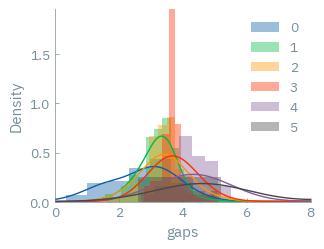

In [132]:
sns.distplot(xtb_outputs_0["gaps"], label="0")
sns.distplot(xtb_outputs_1["gaps"], label="1")
sns.distplot(xtb_outputs_2["gaps"], label="2")
sns.distplot(xtb_outputs_3["gaps"], label="3")
sns.distplot(xtb_outputs_4["gaps"], label="4")
sns.distplot(xtb_outputs_5["gaps"], label="5")
plt.legend()

plt.xlim(0, 8)

## Iteration 6


In [133]:
train_5 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl",
    lines=True,
)
train_5["gap"] = train_5["representation"].apply(lambda x: x[0])

In [134]:
train_data_6 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list()
        + xtb_outputs_0["smiles"].to_list()
        + train_1["label"].to_list()
        + xtb_outputs_1["smiles"].to_list()
        + train_2["label"].to_list()
        + xtb_outputs_2["smiles"].to_list()
        + train_3["label"].to_list()
        + xtb_outputs_3["smiles"].to_list()
        + train_4["label"].to_list()
        + xtb_outputs_4["smiles"].to_list()
        + train_5["label"].to_list()
        + xtb_outputs_5["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list()
        + xtb_outputs_0["gaps"].to_list()
        + train_1["gap"].to_list()
        + xtb_outputs_1["gaps"].to_list()
        + train_2["gap"].to_list()
        + xtb_outputs_2["gaps"].to_list()
        + train_3["gap"].to_list()
        + xtb_outputs_3["gaps"].to_list()
        + train_4["gap"].to_list()
        + xtb_outputs_4["gaps"].to_list()
        + train_5["gap"].to_list()
        + xtb_outputs_5["gaps"].to_list(),
    }
)

<AxesSubplot: >

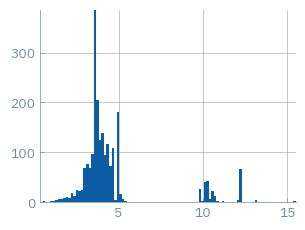

In [136]:
train_data_6["GFN2_HOMO_LUMO_GAP_mean_ev"].hist(bins=100)

In [137]:
train_data_6.dropna(inplace=True)

In [138]:
train_data_6_selected = train_data_6[train_data_6["GFN2_HOMO_LUMO_GAP_mean_ev"] > 5]

In [139]:
len(train_data_6_selected)

292

In [140]:
formatted_6 = formatter(train_data_6_selected)

In [141]:
tune_res_6 = tuner(formatted_6)

Upload progress: 100%|██████████| 76.7k/76.7k [00:00<00:00, 71.4Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl: file-CJTW0nXHbuZPLJYVjhitmWIG
Fine-tune ft-TOztw1CpQzXH88dFy1Nlnck8 has the status "failed" and will not be logged
🎉 wandb sync completed successfully


In [142]:
tune_res_6

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-personal-2023-02-11-20-48-54',
 'ft_id': 'ft-9I13NaUOZNjqmgrU2HurqrUI',
 'date': '20230211_215145',
 'train_file_id': 'file-CJTW0nXHbuZPLJYVjhitmWIG',
 'valid_file_id': None}

In [143]:
querier_6 = Querier("ada:ft-personal-2023-02-11-20-48-54", max_tokens=600)

In [144]:
expected_gaps_6 = generate_desired_dist(6.5, 0.2, 2000)

In [145]:
expected_frame_6 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_6}
)

In [146]:
formatted_test_6 = formatter(expected_frame_6)

In [147]:
completions_6 = defaultdict(list)
smiles_6 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_6(formatted_test_6, temperature=temp)
        extracted = extractor(completions)
        completions_6[temp] = completions
        smiles_6[temp] = extracted
    except Exception:
        pass

In [166]:
from rdkit import Chem

In [185]:
unique_smiles_6 = set()
for t, v in smiles_6.items():
    try:
        unique_smiles_6.update(v)
    except Exception as e:
        print(e)
        pass

In [186]:
len(unique_smiles_6)

2324

In [196]:
valid_smiles_6 = [
    Chem.MolToSmiles(Chem.MolFromSmiles(s.split()[0]))
    for s in unique_smiles_6
    if is_valid(s)
    and not any(
        symb in s
        for symb in [
            "��",
            "やできま",
            "€",
            ".",
            "˚",
            "к",
            "�",
            "I",
            "—",
            "—",
            "}",
            "»",
        ]
    )
]

In [198]:
valid_smiles_6 = list(set(valid_smiles_6))

In [199]:
len(valid_smiles_6)

194

In [200]:
with open("xtb_inputs/6.txt", "w") as handle:
    for smile in valid_smiles_6:
        handle.write(smile + "\n")

In [201]:
with open("xtb_inputs/6_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_6, 100):
        handle.write(smile + "\n")

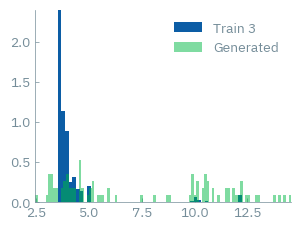

In [12]:
xtb_outputs_6 = pd.read_csv("xtb_outputs/6.csv")
plt.hist(train_3["gap"], bins=50, density=True, label="Train 3")
plt.hist(xtb_outputs_6["gaps"], alpha=0.5, bins=100, label="Generated", density=True)
plt.legend()

(0.0, 8.0)

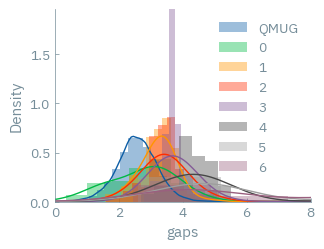

In [210]:
sns.distplot(data["GFN2_HOMO_LUMO_GAP_mean_ev"], label="QMUG")
sns.distplot(xtb_outputs_0["gaps"], label="0")
sns.distplot(xtb_outputs_1["gaps"], label="1")
sns.distplot(xtb_outputs_2["gaps"], label="2")
sns.distplot(xtb_outputs_3["gaps"], label="3")
sns.distplot(xtb_outputs_4["gaps"], label="4")
sns.distplot(xtb_outputs_5["gaps"], label="5")
sns.distplot(xtb_outputs_6["gaps"], label="6")
plt.legend()

plt.xlim(0, 8)

## Iteration 7

In [217]:
train_6 = pd.read_json(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl",
    lines=True,
)
train_6["gap"] = train_5["representation"].apply(lambda x: x[0])

In [218]:
train_data_7 = pd.DataFrame(
    {
        "SMILES": train_0["label"].to_list()
        + xtb_outputs_0["smiles"].to_list()
        + train_1["label"].to_list()
        + xtb_outputs_1["smiles"].to_list()
        + train_2["label"].to_list()
        + xtb_outputs_2["smiles"].to_list()
        + train_3["label"].to_list()
        + xtb_outputs_3["smiles"].to_list()
        + train_4["label"].to_list()
        + xtb_outputs_4["smiles"].to_list()
        + train_5["label"].to_list()
        + xtb_outputs_5["smiles"].to_list()
        + train_6["label"].to_list()
        + xtb_outputs_6["smiles"].to_list(),
        "GFN2_HOMO_LUMO_GAP_mean_ev": train_0["gap"].to_list()
        + xtb_outputs_0["gaps"].to_list()
        + train_1["gap"].to_list()
        + xtb_outputs_1["gaps"].to_list()
        + train_2["gap"].to_list()
        + xtb_outputs_2["gaps"].to_list()
        + train_3["gap"].to_list()
        + xtb_outputs_3["gaps"].to_list()
        + train_4["gap"].to_list()
        + xtb_outputs_4["gaps"].to_list()
        + train_5["gap"].to_list()
        + xtb_outputs_5["gaps"].to_list()
        + train_6["gap"].to_list()
        + xtb_outputs_6["gaps"].to_list(),
    }
)

<AxesSubplot: >

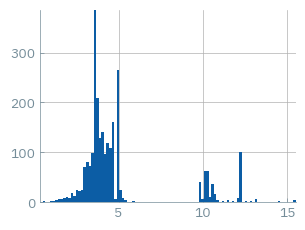

In [219]:
train_data_7["GFN2_HOMO_LUMO_GAP_mean_ev"].hist(bins=100)

In [220]:
train_data_7_selected = train_data_7[
    (train_data_7["GFN2_HOMO_LUMO_GAP_mean_ev"] > 5)
    & (train_data_7["GFN2_HOMO_LUMO_GAP_mean_ev"] < 10)
]

In [221]:
len(train_data_7_selected)

134

In [222]:
formatted_7 = formatter(train_data_7_selected)

In [223]:
tune_res_7 = tuner(formatted_7)

Upload progress: 100%|██████████| 31.5k/31.5k [00:00<00:00, 58.9Mit/s]


Uploaded file from /Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl: file-xQW5t4tEhOAjRVIBdGgYM3lL
Fine-tune ft-TOztw1CpQzXH88dFy1Nlnck8 has the status "failed" and will not be logged
🎉 wandb sync completed successfully


In [224]:
tune_res_7

{'base_model': 'ada',
 'batch_size': None,
 'n_epochs': 4,
 'learning_rate_multiplier': None,
 'run_name': None,
 'wandb_sync': True,
 'outdir': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802',
 'train_filename': '/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/bandgap/biasing/manual/out/20230211_155802/train.jsonl',
 'valid_filename': 'None',
 'model_name': 'ada:ft-personal-2023-02-11-22-26-49',
 'ft_id': 'ft-OYQahLh81yjYMSa4awoONIQA',
 'date': '20230211_232944',
 'train_file_id': 'file-xQW5t4tEhOAjRVIBdGgYM3lL',
 'valid_file_id': None}

In [226]:
querier_7 = Querier("ada:ft-personal-2023-02-11-22-26-49", max_tokens=600)

In [227]:
expected_gaps_7 = generate_desired_dist(6.5, 0.2, 2000)

In [228]:
expected_frame_7 = pd.DataFrame(
    {"SMILES": ["SMILE"] * 2000, "GFN2_HOMO_LUMO_GAP_mean_ev": expected_gaps_7}
)

In [229]:
formatted_test_7 = formatter(expected_frame_7)

In [230]:
completions_7 = defaultdict(list)
smiles_7 = defaultdict(list)

for temp in TEMPERATURES:
    try:
        completions = querier_7(formatted_test_7, temperature=temp)
        extracted = extractor(completions)
        completions_7[temp] = completions
        smiles_7[temp] = extracted
    except Exception:
        pass

In [231]:
unique_smiles_7 = set()
for t, v in smiles_7.items():
    try:
        unique_smiles_7.update(v)
    except Exception as e:
        print(e)
        pass

In [232]:
valid_smiles_7 = [
    Chem.MolToSmiles(Chem.MolFromSmiles(s.split()[0]))
    for s in unique_smiles_7
    if is_valid(s)
    and not any(
        symb in s
        for symb in [
            "��",
            "やできま",
            "€",
            ".",
            "˚",
            "к",
            "�",
            "I",
            "—",
            "—",
            "}",
            "»",
        ]
    )
]

In [ ]:
with open("xtb_inputs/7.txt", "w") as handle:
    for smile in valid_smiles_7:
        handle.write(smile + "\n")

In [234]:
with open("xtb_inputs/7_sample.txt", "w") as handle:
    for smile in random.sample(valid_smiles_7, 100):
        handle.write(smile + "\n")

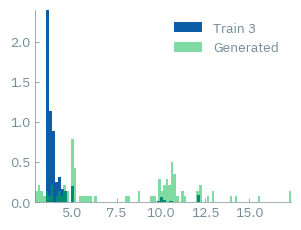

In [13]:
xtb_outputs_7 = pd.read_csv("xtb_outputs/7.csv")
plt.hist(train_3["gap"], bins=50, density=True, label="Train 3")
plt.hist(xtb_outputs_7["gaps"], alpha=0.5, bins=100, label="Generated", density=True)
plt.legend()

(0.0, 8.0)

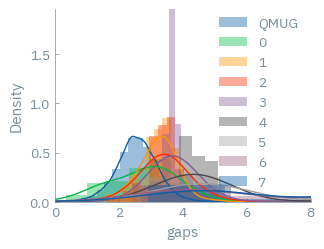

In [236]:
sns.distplot(data["GFN2_HOMO_LUMO_GAP_mean_ev"], label="QMUG")
sns.distplot(xtb_outputs_0["gaps"], label="0")
sns.distplot(xtb_outputs_1["gaps"], label="1")
sns.distplot(xtb_outputs_2["gaps"], label="2")
sns.distplot(xtb_outputs_3["gaps"], label="3")
sns.distplot(xtb_outputs_4["gaps"], label="4")
sns.distplot(xtb_outputs_5["gaps"], label="5")
sns.distplot(xtb_outputs_6["gaps"], label="6")
sns.distplot(xtb_outputs_7["gaps"], label="7")
plt.legend()

plt.xlim(0, 8)

In [33]:
data["GFN2_HOMO_LUMO_GAP_mean_ev"].mean()

2.582679103223603

In [22]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-1.5, vmax=7.5)

In [23]:
cmap = mpl.cm.get_cmap("RdBu_r")

In [24]:
import seaborn as sns
from scipy.constants import golden

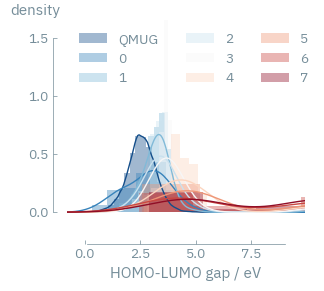

In [32]:
fig, ax = plt.subplots(figsize=(3.25, 3.25 / golden * 1.5))
ax.set_facecolor("white")
# sns.distplot(gaps, ax=ax, label="QMUGs", color=cmap(norm(0)))
# sns.distplot(biased_gap_res['gap'], label="it. 0", ax=ax, color=cmap(norm(1)))
# sns.distplot(first_iteration_gap_res['gap'], label="it. 1", ax=ax,
#              color=cmap(norm(2)))
# sns.distplot(second_iteration_gap_res['gap'], label="it. 2", ax=ax
#              , color=cmap(norm(3)))
# sns.distplot(third_iteration_gap_res['gap'], label="it. 3", ax=ax,
#              color=cmap(norm(4)))
# sns.distplot(fourth_iteration_gap_res['gap'], label="it. 4", ax=ax,
#              color=cmap(norm(5)))

sns.distplot(data["GFN2_HOMO_LUMO_GAP_mean_ev"], label="QMUG", ax=ax, color=cmap(norm(-1)))
sns.distplot(xtb_outputs_0["gaps"], label="0", ax=ax, color=cmap(norm(0)))
sns.distplot(xtb_outputs_1["gaps"], label="1", ax=ax, color=cmap(norm(1)))
sns.distplot(xtb_outputs_2["gaps"], label="2", ax=ax, color=cmap(norm(2)))
sns.distplot(xtb_outputs_3["gaps"], label="3", ax=ax, color=cmap(norm(3)))
sns.distplot(xtb_outputs_4["gaps"], label="4", ax=ax, color=cmap(norm(4)))
sns.distplot(xtb_outputs_5["gaps"], label="5", ax=ax, color=cmap(norm(5)))
sns.distplot(xtb_outputs_6["gaps"], label="6", ax=ax, color=cmap(norm(6)))
sns.distplot(xtb_outputs_7["gaps"], label="7", ax=ax, color=cmap(norm(7)))


ax.set_xlim(0, 10)
ax.legend(loc="upper left", ncol=3)
ax.set_ylabel("")
ylabel_top("density")
ax.set_xlabel("HOMO-LUMO gap / eV")

range_frame(ax, np.array([0.1, 9]), np.array([0, 1.5]))

fig.tight_layout()
fig.savefig("biasing_gaps_100.pdf", bbox_inches="tight")